In [1]:
import sys
sys.path.append('../')

import numpy as np
from cpat import Compatibility, init_cpat, train_cpat
from bproj import BaryProj, init_bproj, train_bproj
from score import init_score, train_score
from scones import SCONES
import matplotlib.pyplot as plt
from score import Score
from config import Config
from datasets import Gaussian, SwissRoll
import json
import torch
import os
from sinkhorn import sample_stats, sq_bw_distance, sinkhorn, bw_uvp
from collections import defaultdict
'''
Given a configuration, train SCONES and BP and output
'''

cnf = Config("Swiss-Roll",
             source="circle",
             target="swiss-roll",
             l = 2,
             score_lr=0.000001,
             score_iters=1000,
             score_bs=500,
             score_noise_init=3,
             score_noise_final=0.01,
             scones_iters=2000,
             scones_bs=1000,
             device='cuda',
             score_n_classes = 10,
             score_steps_per_class = 300,
             score_sampling_lr = 0.00001,
             scones_samples_per_source=100,
             seed=2039)
torch.manual_seed(cnf.seed)
np.random.seed(cnf.seed)

In [21]:
class DiagonalMatching:

    def __init__(self, n_samples=None, mode='initial'):
        self.n_samples = n_samples
        self.mode = mode
        self.dim = 2
        if n_samples is None and mode not in ['initial', 'final']:
            raise ValueError('mode must be either initial or final')
    def sample(self):
        n = self.n_samples//2+1

        left_square = np.stack([np.random.uniform(-1.2, -1., size=(n,))*2-5, np.linspace(-.1, .5, n)*4+3], axis=1)
        right_square = np.stack([np.random.uniform(1., 1.2, size=(n,))*2+5, np.linspace(-.1, .5, n)*4+3], axis=1)

        top_square = np.stack([np.linspace(-.3, .3, n)*4, np.random.uniform(.8, 1., size=(n,))*2+3], axis=1)
        bottom_square = np.stack([np.linspace(-.3, .3, n)*4, np.random.uniform(-1.5, -1.3, size=(n,))*2-3], axis=1)

        rand_shuffling = np.random.permutation(self.n_samples)

        return {
            "initial": torch.from_numpy(np.concatenate([left_square, top_square], axis=0)[:self.n_samples][rand_shuffling]).float(),
            "final": torch.from_numpy(np.concatenate([right_square, bottom_square], axis=0)[:self.n_samples][rand_shuffling]).float()
        }
        
    def rvs(self, size=(1,)):
        n = size[0]//2+1
        rand_shuffling = np.random.permutation(size[0])

        if self.mode == 'initial':
            left_square = np.stack([np.random.uniform(-1.2, -1., size=(n,))*2-5, np.linspace(-.1, .5, n)*4+3], axis=1)
            top_square = np.stack([np.linspace(-.3, .3, n)*4, np.random.uniform(.8, 1., size=(n,))*2+3], axis=1)
            return np.concatenate([left_square, top_square], axis=0)[:size[0]][rand_shuffling]
        elif self.mode == 'final':
            right_square = np.stack([np.random.uniform(1., 1.2, size=(n,))*2+5, np.linspace(-.1, .5, n)*4+3], axis=1)
            bottom_square = np.stack([np.linspace(-.3, .3, n)*4, np.random.uniform(-1.5, -1.3, size=(n,))*2-3], axis=1)
            return np.concatenate([right_square, bottom_square], axis=0)[:size[0]][rand_shuffling]
        else:
            raise ValueError('mode must be either initial or final')
        

  0%|          | 0/5000 [01:23<?, ?it/s]


In [22]:
cnf.source_dist = DiagonalMatching(n_samples=cnf.scones_samples_per_source, mode='initial')
cnf.target_dist = DiagonalMatching(n_samples=cnf.scones_samples_per_source, mode='final')

In [23]:
cpat = init_cpat(cnf)

# If TRUE, ignore any existing pretrained models and overwrite them.
OVERWRITE = True

# Create directories for saving pretrained models if they do not already exist
touch_path = lambda p: os.makedirs(p) if not os.path.exists(p) else None
for path in ['', 'cpat', 'bproj', 'ncsn']:
    touch_path('pretrained/' + path)

# Search for and load any existing pretrained models
if ((not OVERWRITE) and os.path.exists(os.path.join("pretrained/cpat", cnf.name))):
    cpat.load(os.path.join("pretrained/cpat", cnf.name, "cpat.pt"))
else:
    train_cpat(cpat, cnf, verbose=True)

bproj = init_bproj(cpat, cnf)

if ((not OVERWRITE) and os.path.exists(os.path.join("pretrained/bproj", cnf.name))):
    bproj.load(os.path.join("pretrained/bproj", cnf.name, "bproj.pt"))
else:
    train_bproj(bproj, cnf, verbose=True)

score = init_score(cnf)

if ((not OVERWRITE) and os.path.exists(os.path.join("pretrained/score", cnf.name))):
    score.load(os.path.join("pretrained/score", cnf.name, "score.pt"))
else:
    train_score(score, cnf, verbose=True)

Objective: 1.65E+01:   0%|          | 7/5000 [00:00<06:33, 12.67it/s]


Covariance:
[[13.21052136  1.80175672  2.15603583  2.71069301]
 [ 1.80175672  0.49729165  0.25594436  0.55001788]
 [ 2.15603583  0.25594436  0.48303519  0.37364881]
 [ 2.71069301  0.55001788  0.37364881  0.72184773]]


Objective: 1.40E+01:  20%|██        | 1007/5000 [00:12<00:46, 85.81it/s]


Covariance:
[[13.21209737  1.80191746 13.22542666 16.99858912]
 [ 1.80191746  0.49652386  1.94693408  2.37262511]
 [13.22542666  1.94693408 14.81011482 16.93330457]
 [16.99858912  2.37262511 16.93330457 22.44790512]]


Objective: 9.72E+00:  40%|████      | 2007/5000 [00:24<00:35, 85.46it/s]


Covariance:
[[13.20642928  1.79899204 13.14055822 17.01505165]
 [ 1.79899204  0.49676438  1.65515806  2.45759527]
 [13.14055822  1.65515806 14.13836627 16.97206512]
 [17.01505165  2.45759527 16.97206512 22.46823484]]


Objective: 7.42E+00:  60%|██████    | 3007/5000 [00:35<00:23, 85.40it/s]


Covariance:
[[13.21058684  1.79968854 13.19917896 16.98108308]
 [ 1.79968854  0.49641129  1.78371853  2.3803516 ]
 [13.19917896  1.78371853 13.98347738 17.0905751 ]
 [16.98108308  2.3803516  17.0905751  22.3198038 ]]


Objective: 3.19E+00:  80%|████████  | 4007/5000 [00:47<00:15, 62.98it/s]


Covariance:
[[13.20960954  1.80196689 13.16993276 16.92809634]
 [ 1.80196689  0.49764733  1.79014722  2.39869778]
 [13.16993276  1.79014722 13.62936838 17.10653377]
 [16.92809634  2.39869778 17.10653377 22.09968336]]


Objective: 6.41E-01: 100%|██████████| 1000/1000 [00:19<00:00, 51.89it/s]


In [24]:
scones = SCONES(cpat, score, bproj, cnf)

# Sample and test the model 
n_samples = 1200
Xs = cnf.source_dist.rvs(size=(n_samples,))
Xs_th = torch.FloatTensor(Xs).to(cnf.device)

bproj_Xs_th = bproj.projector(Xs_th).detach()
bproj_Xs = bproj_Xs_th.cpu().numpy()


scones_samples = scones.sample(Xs_th, verbose=True, source_init=True)

100%|██████████| 10/10 [1:14:51<00:00, 449.17s/it]


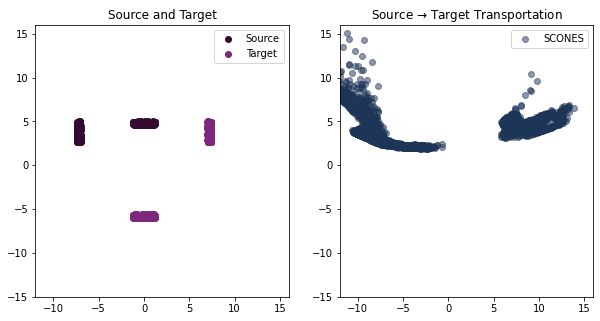

In [26]:
plt.subplot(1, 2, 1)
plt.scatter(*Xs.T, color="#330C2F", label="Source")
plt.scatter(*cnf.target_dist.rvs(size=(n_samples,)).T, color="#7B287D", label="Target")
plt.legend()
plt.ylim(-15, 16)
plt.xlim(-12, 16)
plt.title("Source and Target")

plt.subplot(1, 2, 2)
# plt.scatter(*bproj_Xs.T, label="BPROJ", color="#7067CF", alpha=0.5)
plt.scatter(*scones_samples.reshape(-1, 2).T, label="SCONES", color="#1d3557", alpha=0.5)
plt.legend()
plt.ylim(-15, 16)
plt.xlim(-12, 16)
plt.title("Source $\\to$ Target Transportation")

plt.gcf().set_size_inches(10, 5)
plt.savefig("Source_2_Target.png")
plt.show()

#np.save("Cutout_Bproj_Gaussian->SwissRoll.npy", bproj_Xs)
#np.save("Cutout_SCONES_Gaussian->SwissRoll.npy", scones_samples)
np.save("Cutout.npy", scones_samples)
np.save("Sources.npy", Xs)
np.save("Target.npy", cnf.target_dist.rvs(size=(n_samples,)))

In [41]:
scones_samples.shape

(30, 100, 2)

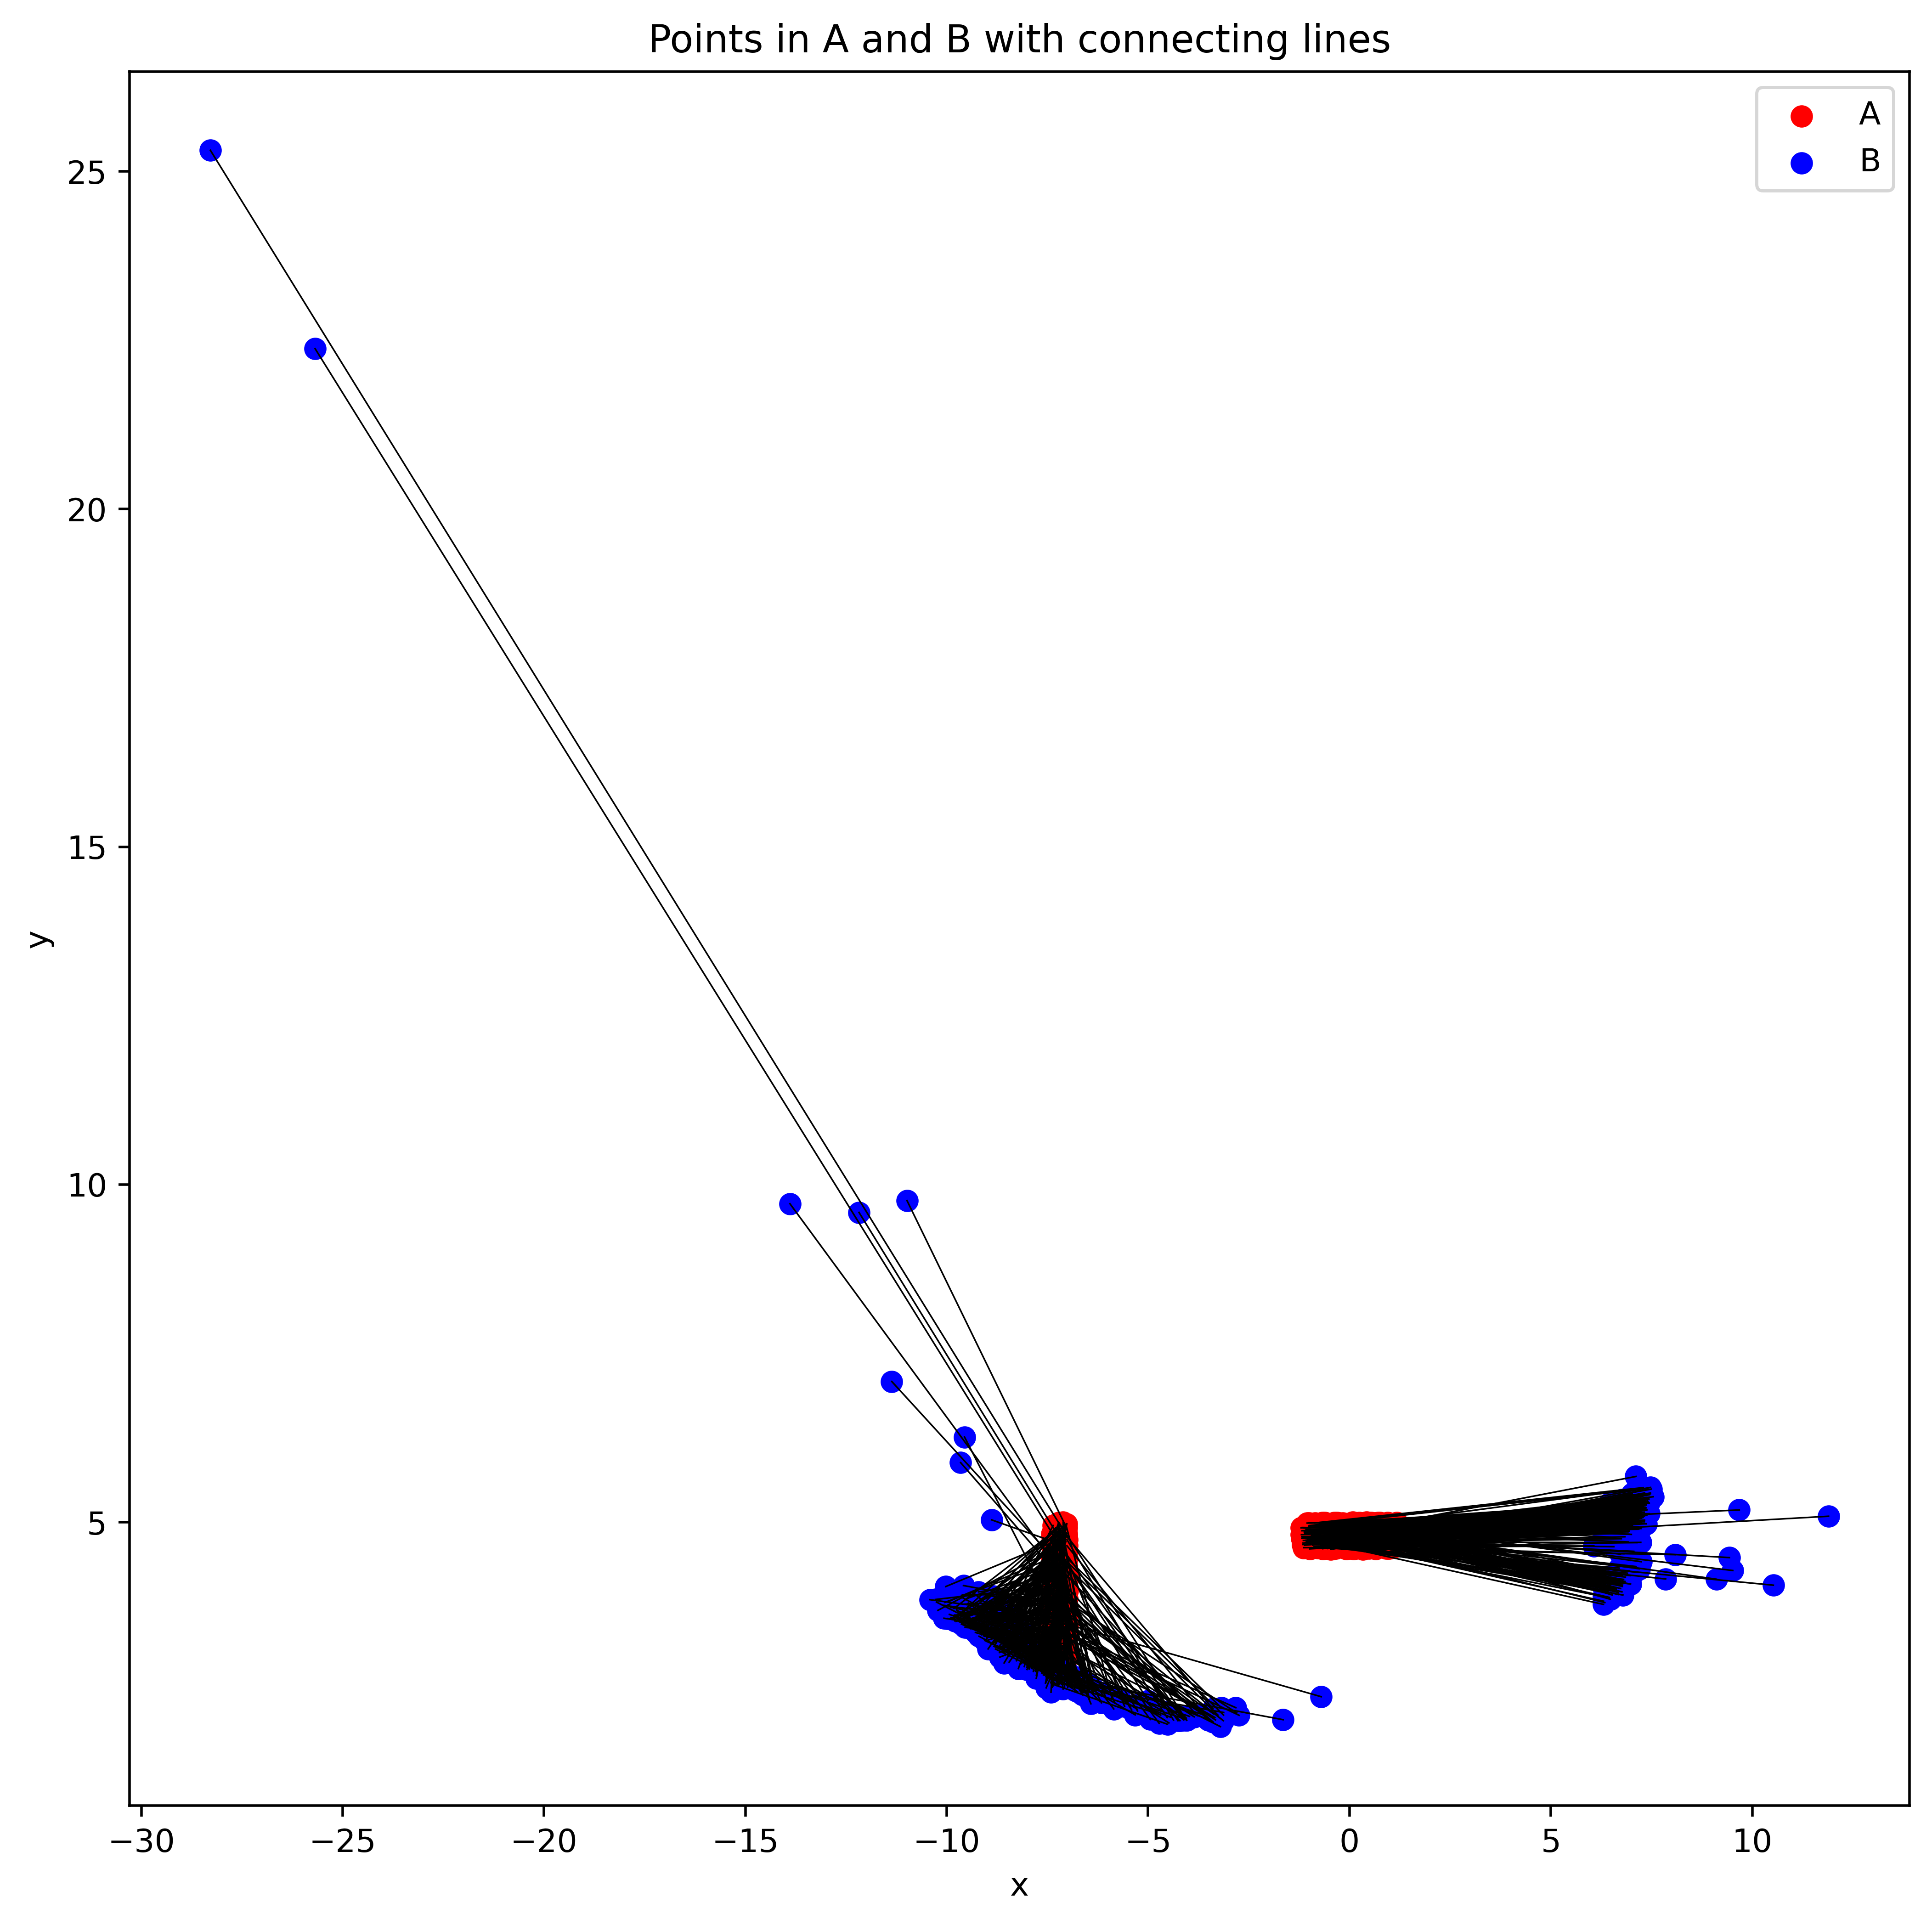

In [27]:
# Generating random points for A and B
A = Xs
B = scones_samples[:,0,:]
plt.figure( figsize=(10,10), dpi=500)
# Plotting points in A and B
plt.scatter(A[:, 0], A[:, 1], color='red', label='A')
plt.scatter(B[:, 0], B[:, 1], color='blue', label='B')

# Drawing lines from A to B
for point_A, point_B in zip(A, B):
    plt.plot([point_A[0], point_B[0]], [point_A[1], point_B[1]], color='black',linewidth=0.5 )

plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Points in A and B with connecting lines')
plt.savefig('arrow.jpg')
plt.show()